# COVID-19 Tweets: Exploratory Data Analysis and Text Analysis
## Alexis Virgen - ITESM (Mexico)
### On this notebook I experimented for the first time with the data and implemented sentiment analysis for one date, on the [main]() notebook is the complete analysis for this project

The data is collected from [here](https://www.kaggle.com/lopezbec/covid19-tweets-dataset?select=covid+Tweets_ID),
they provide a repository containing an ongoing collection of tweets IDs associated with the novel coronavirus COVID-19. The dataset contains Tweets’ ids dating back to January 22th, 2020.

I created a [script](https://github.com/SAlexisvf/COVID-Tweets-EDA/blob/master/tweet_collector.py) to collect the tweets from tweets ID's on a txt file, transform them into a Pandas dataframe and save it as a csv file.

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [178]:
df = pd.read_csv('data/2020_03_13.csv')

## We start with an initial EDA

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_location   6723 non-null   object 
 1   user_followers  10000 non-null  float64
 2   retweet_count   10001 non-null  object 
 3   favorite_count  10000 non-null  float64
 4   user_verified   10000 non-null  object 
 5   date            10000 non-null  object 
 6   lang            10000 non-null  object 
 7   text            10000 non-null  object 
 8   hashtags        3195 non-null   object 
 9   source          9999 non-null   object 
dtypes: float64(2), object(8)
memory usage: 781.5+ KB


In [180]:
df.head()

,user_location,user_followers,retweet_count,favorite_count,user_verified,date,lang,text,hashtags,source
0,Brasília,1718.0,22085,0.0,False,2020-03-13 02:24:41,pt,RT @baianolol1: Para evitar a transmissão do c...,NaN,Twitter for iPhone
1,NaN,2210.0,27,0.0,False,2020-03-13 05:54:16,en,RT @chhuti_is: I so miss UPA 1. I would do any...,"['BlackFriday', 'Covid_19', 'Sensex']",Twitter Web App
2,Puerto Rico,1151.0,58863,0.0,False,2020-03-13 18:30:34,en,"RT @GhaydaaSamaan: Earth is taking a break, a ...","['CoronaVirusUpdate', 'Covid_19', 'كورونا']",Twitter for iPhone
3,"Belém, Pará",3920.0,9533,0.0,False,2020-03-13 17:15:15,pt,RT @OskarSays: BOLSONARO DEU negativo para cov...,NaN,Twitter for iPhone
4,NaN,249.0,42495,0.0,False,2020-03-13 14:28:45,en,RT @SOUTHSKTH: reminder that there are actual ...,NaN,Twitter for iPhone


In [181]:
# filtering data with 'language = en'
df = df[df.lang == "en"].reset_index(drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5594 entries, 0 to 5593
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_location   4039 non-null   object 
 1   user_followers  5594 non-null   float64
 2   retweet_count   5594 non-null   object 
 3   favorite_count  5594 non-null   float64
 4   user_verified   5594 non-null   object 
 5   date            5594 non-null   object 
 6   lang            5594 non-null   object 
 7   text            5594 non-null   object 
 8   hashtags        1352 non-null   object 
 9   source          5593 non-null   object 
dtypes: float64(2), object(8)
memory usage: 437.2+ KB


### Plot the missed values percentage per column

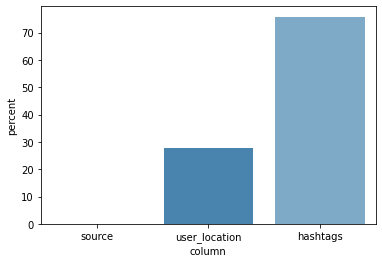

In [182]:
missed = pd.DataFrame()
missed['column'] = df.columns

missed['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missed = missed.sort_values('percent')
missed = missed[missed['percent']>0]

sns.barplot(x='column', y='percent', data=missed, palette="Blues_d")

In [183]:
df['user_location'].isnull().sum()

1555

In [184]:
def plot_frequency_charts(df, feature, title, pallete):
    freq_df = pd.DataFrame()
    freq_df[feature] = df[feature]
    
    f, ax = plt.subplots(1,1, figsize=(16,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette=pallete)
    g.set_title("Number and percentage of {}".format(title))

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 

    plt.title('Frequency of {} tweeting about Corona'.format(feature))
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(title, fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

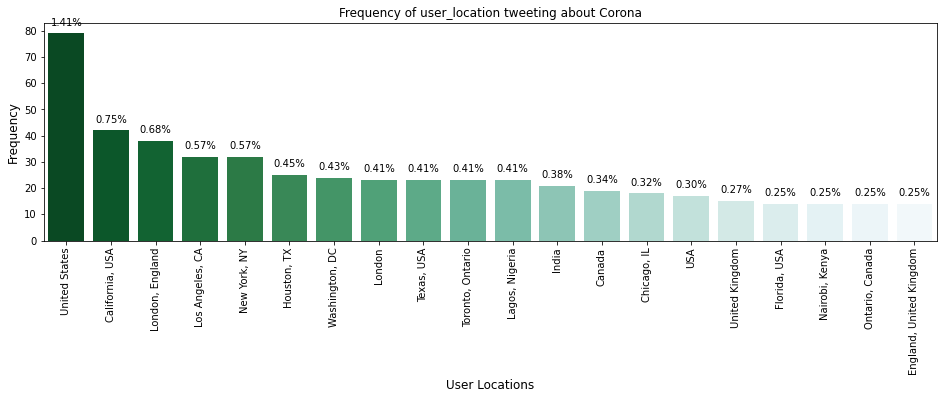

In [185]:
plot_frequency_charts(df, 'user_location', 'User Locations', 'BuGn_r')

## Data Cleaning

### Text normalization
Remove links, hashtags, punctuation, mentions, etc.

In [186]:
import re

for i in range(df.shape[0]) :
    df['text'][i] = ' '.join(re.sub("(RT @[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(#[A-Za-z0-9]+)", " ", df['text'][i]).split()).lower()

/Users/salvadoralexisvirgenflores/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [187]:
top_fav = df[['favorite_count','text']].sort_values('favorite_count',ascending = False)[:5].reset_index()

print('Top 5 favorite tweets')
for i in range(5):
    print()
    print('favs: ' + str(top_fav['favorite_count'][i]))
    print(top_fav['text'][i])    

Top 5 favorite tweets

favs: 2522.0
breaking news the dallas cowboys have announced they will not be participating in the nfl playoffs this upcoming season due to covid 19

favs: 1900.0
chinese billionaire steps in to donate covid 19 testing kits and masks to the us which still seems incapable of testing patients despite months of advance warning that this crisis was coming

favs: 694.0
updated odds of catching covid 19 mar 1 in 4600 apr 1 in 140 may 1 in 5 jun 1 in 2 jul 1 in 12 aug 1 in 150 assumes continue current trajectory without radical interventions hopefully this gives context to govt comments about timing interventions right

favs: 492.0
covid 19 very contagious and 6 times as lethal as flu worse if old smoker diabetic obese or heart disease we will see exponential spread slow spread to reduce unnecessary deaths isolate hygiene sleep well eat well exercise sunshine

favs: 356.0
army s donated 500k to covid efforts after cancelled bts shows it doesn t take a harmless racist re

In [188]:
top_rt = df[['retweet_count','text']].sort_values('retweet_count',ascending = False)[:5].reset_index()

print('Top 5 most retweeted tweets')
for i in range(5):
    print()
    print('rts: ' + str(top_rt['retweet_count'][i]))
    print(top_rt['text'][i]) 

Top 5 most retweeted tweets

rts: 999
discrimination is illegal in new york city if you experience or see any sort of hate crime or discrimination related to co

rts: 997
uploading now urgently will check back in an hour if i haven t been arrested still pulled over as i type roxhamroad

rts: 997
uploading now urgently will check back in an hour if i haven t been arrested still pulled over as i type roxhamroad

rts: 997
uploading now urgently will check back in an hour if i haven t been arrested still pulled over as i type roxhamroad

rts: 997
uploading now urgently will check back in an hour if i haven t been arrested still pulled over as i type roxhamroad


In [189]:
len(df['text'].value_counts())

3079

In [190]:
# We saw above retweets are count as tweets, we need to drop them
df = df.drop_duplicates(subset='text', keep="first").reset_index()

In [191]:
top_rt = df[['retweet_count','text']].sort_values('retweet_count',ascending = False)[:5].reset_index()

print('Top 5 most retweeted tweets')
for i in range(5):
    print()
    print('rts: ' + str(top_rt['retweet_count'][i]))
    print(top_rt['text'][i]) 

Top 5 most retweeted tweets

rts: 999
discrimination is illegal in new york city if you experience or see any sort of hate crime or discrimination related to co

rts: 997
uploading now urgently will check back in an hour if i haven t been arrested still pulled over as i type roxhamroad

rts: 996
i shared my story on the importance of self quarantine and my 14 days experience of self isolation but dailynation wen

rts: 990
as a precautionary measure against the spread of covid 19 novel coronavirus the rashtrapati bhavan will remain closed

rts: 99
today repdwstweets asked cdcgov s dr redfield who s in charge of covid testing he couldn t answer he then looke


In [192]:
# next we will remove stop words
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

ENGLISH_STOP_WORDS

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [193]:
#Removing Stop Words
df['text'] = df['text'].apply(lambda tweets: ' '.join([word for word in tweets.split() if word not in ENGLISH_STOP_WORDS]))

In [194]:
from textblob import TextBlob

df['sentiment'] = 0
df['polarity'] = None

for i, tweet in enumerate(df['text']) :
    blob = TextBlob(tweet)
    df['polarity'][i] = blob.sentiment.polarity
    if blob.sentiment.polarity > 0 :
        df['sentiment'][i] = 'positive'
    elif blob.sentiment.polarity < 0 :
        df['sentiment'][i] = 'negative'
    else :
        df['sentiment'][i] = 'neutral'

/Users/salvadoralexisvirgenflores/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/salvadoralexisvirgenflores/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/salvadoralexisvirgenflores/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [195]:
df.head()

,index,user_location,user_followers,retweet_count,favorite_count,user_verified,date,lang,text,hashtags,source,sentiment,polarity
0,0,NaN,2210.0,27,0.0,False,2020-03-13 05:54:16,en,miss upa 1 bring days blackfriday covid 19 sensex,"['BlackFriday', 'Covid_19', 'Sensex']",Twitter Web App,neutral,0
1,1,Puerto Rico,1151.0,58863,0.0,False,2020-03-13 18:30:34,en,earth taking break needed break coronavirusupd...,"['CoronaVirusUpdate', 'Covid_19', 'كورونا']",Twitter for iPhone,neutral,0
2,2,NaN,249.0,42495,0.0,False,2020-03-13 14:28:45,en,reminder actual businesses owned america chine...,NaN,Twitter for iPhone,neutral,0
3,3,Blighttown,1305.0,13,0.0,False,2020-03-13 21:16:34,en,love covid,NaN,Twitter Web App,positive,0.5
4,4,"Indiana, USA",3362.0,7499,0.0,False,2020-03-13 00:07:29,en,media hysteria china virus irresponsible disea...,NaN,Twitter Web App,neutral,0


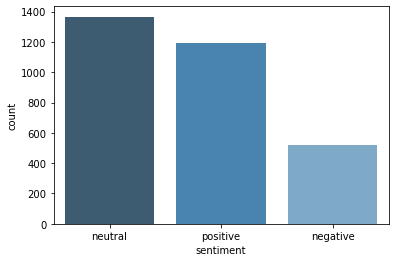

In [196]:
sns.countplot(x='sentiment', data = df, palette='Blues_d')

In [197]:
from wordcloud import WordCloud

def generate_wordcloud(data):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(data))
    
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

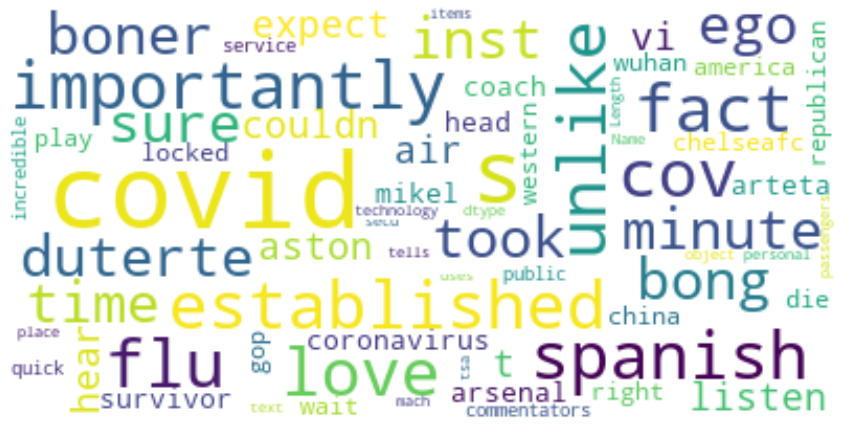

In [198]:
generate_wordcloud(df['text'][df['sentiment'] == 'positive'])

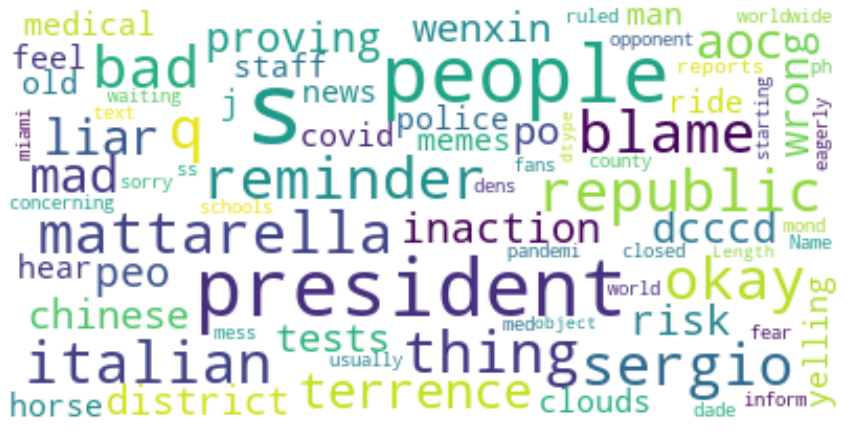

In [199]:
generate_wordcloud(df['text'][df['sentiment'] == 'negative'])

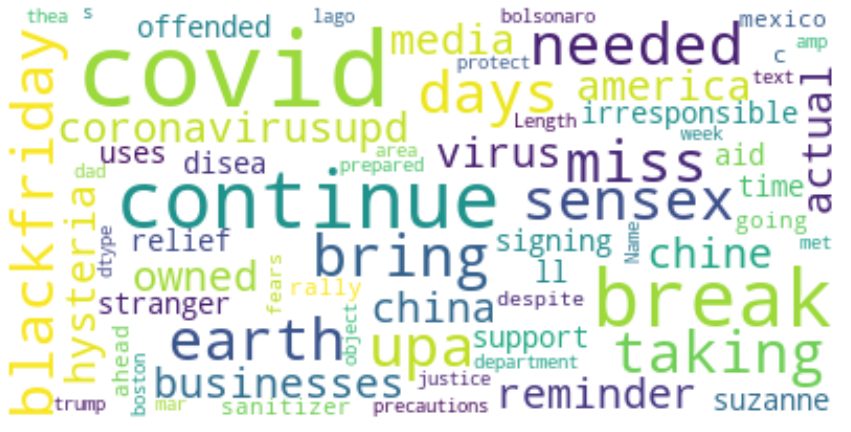

In [200]:
generate_wordcloud(df['text'][df['sentiment'] == 'neutral'])

## Next step
The next step will be to analyse how this changes over time, we are going to analyse some of the important days on the covid timeline